In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

%matplotlib notebook

In [5]:
%matplotlib notebook

In [6]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_compare'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


In [7]:
target_color

['maroon',
 'orangered',
 'darkgoldenrod',
 'olivedrab',
 'teal',
 'steelblue',
 'midnightblue',
 'darkmagenta']

In [5]:
#Pre-processing: 

#Trial boundaries:
trial_start = np.where((df['bin']==-10.0))[0]
trial_stop = np.where((df['trial_stop']==1))[0]
trial_bound = np.vstack((trial_start,trial_stop)).T
num_trials = trial_bound.shape[0]

#-----------------------------------------------------------------------------------------------
#Time till end of trial: 
df['bin_end'] = 0
df['prog'] = 0

for bnd in trial_bound:
    bin_data = df['bin'][bnd[0]:bnd[1]+1]
    last_bin = bin_data.iloc[-1]
    bin_end = last_bin-bin_data
    prog = bin_data/last_bin
    #ASSIGN:
    df['bin_end'][bnd[0]:bnd[1]+1] = bin_end
    df['prog'][bnd[0]:bnd[1]+1] = prog
    
#-----------------------------------------------------------------------------------------------    
#Cond Trial number
for task in [1]:#range(num_tasks):
    for target in [7]: #range(num_targets):
        cond_sel = (df['task']==task) & (df['target']==target)
        trial_start = (df['bin']==0) & cond_sel 
        trial_stop = (df['bin_end']==0) & cond_sel
        trial_bnd = np.vstack((np.where(trial_start)[0], np.where(trial_stop)[0]))
        for i,bnd in enumerate(trial_bnd.T):
            print(i, bnd)
            df.loc[bnd[0]:bnd[1], 'trial_cond'] = i
    
#-----------------------------------------------------------------------------------------------    
#Polar coordinates: 
# 1) Convert stuff to polar, 2) center angles at target angle, 3) calculate distance to target
# 1) Convert stuff to polar
df['p_mag'], df['p_angle'] = bmi_b.cartesian2polar(df['kin_py'], df['kin_px'])
df['v_mag'], df['v_angle'] = bmi_b.cartesian2polar(df['kin_vy'], df['kin_vx'])
df['u_p_mag'], df['u_p_angle'] = bmi_b.cartesian2polar(df['u_py'], df['u_px'])
df['u_v_mag'], df['u_v_angle'] = bmi_b.cartesian2polar(df['u_vy'], df['u_vx'])
# 2) Center @ target angle: 
d_list = ['p_angle', 'v_angle', 'u_p_angle', 'u_v_angle']
for d in d_list:
    data = df[d]
    zeros = np.zeros(data.shape)
    t_angle = target_angle[df['target'].astype(int)]
    df[d+'_ctr'] = bmi_b.center_angle(df[d], zeros, t_angle)
# 3) distance to target
error = df.loc[:, 'kin_px':'kin_py']-target_pos[df['target'].astype(int),:]
df['d2target'] = np.linalg.norm(error,ord=2,axis=1)
df['x_error'] = error.loc[:,'kin_px']
df['y_error'] = error.loc[:,'kin_py']    

#-----------------------------------------------------------------------------------------------
#BINNING: 
#1) magnitude bins: 
num_mag_bins = 4
mag_bin_perc = np.array([0,25,50,75,100])
mag_data = df['u_v_mag']
#mag_data = df['u_v_mag'][df['bin']>=0] - we didn't do this, because we want to be able to bin all data, negative bins
mag_bin = np.percentile(mag_data, mag_bin_perc)
mag_bin_edges = np.vstack((mag_bin[0:-1], mag_bin[1:]))
mag_bin_c = mag_bin_edges.mean(axis=0)

#2) angle bins: 
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
angle_bin_c = np.linspace(T0_angle, T0_angle+np.pi*2, num=num_angle_bins+1, endpoint=True)
# angle_bin_c[angle_bin_c > np.pi] = angle_bin_c[angle_bin_c > np.pi] - 2*np.pi #center at angle 0 instead of 180
angle_bin = angle_bin_c-np.pi*2/16.0
# angle_bin[angle_bin < -np.pi] = angle_bin[angle_bin < -np.pi] + 2*np.pi
angle_bin_edges = np.vstack((angle_bin[0:-1], angle_bin[1:]))

#center angles for binning: 
angle_center_for_binning = (angle_bin[-1]+angle_bin[0])/2.0
print('angle_center:', angle_center_for_binning*180/np.pi)

angle_vars = ['p_angle', 'v_angle', 'u_p_angle', 'u_v_angle']
for d in angle_vars:
    df[d] = bmi_b.center_angle_v2(np.array(df[d]), angle_center_for_binning)
print('min centered angle:', np.min(df['u_v_angle'])*180/np.pi)
print('max centered angle:', np.max(df['u_v_angle'])*180/np.pi)

#BIN DATA: 
bin_dic = {}
bin_dic[0] = mag_bin_edges
bin_dic[1] = angle_bin_edges

data2bin = np.array(df[['u_v_mag','u_v_angle']])
bin_r, hist_r = bmi_b.bin_vec_data(data2bin, bin_dic)
df['u_v_mag_bin']=bin_r[:,0]
df['u_v_angle_bin']=bin_r[:,1]

c:\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('angle_center:', 22.5)
('min centered angle:', -157.4975492637699)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


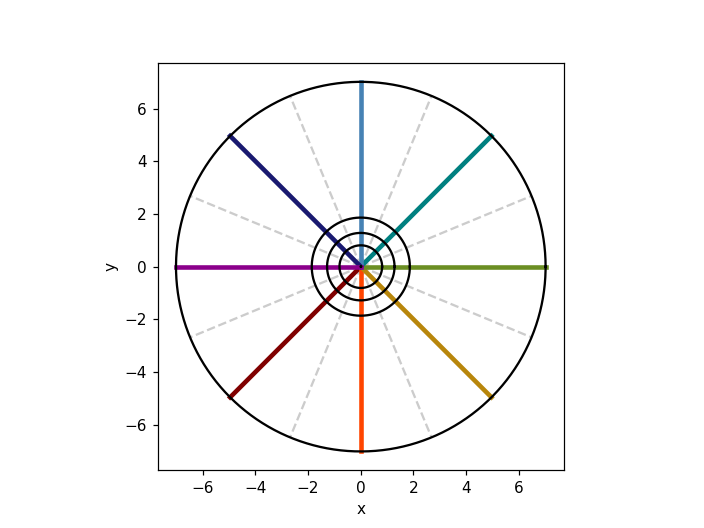

In [6]:
bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges, target_color)

### Visualize Binning: 

<IPython.core.display.Javascript object>


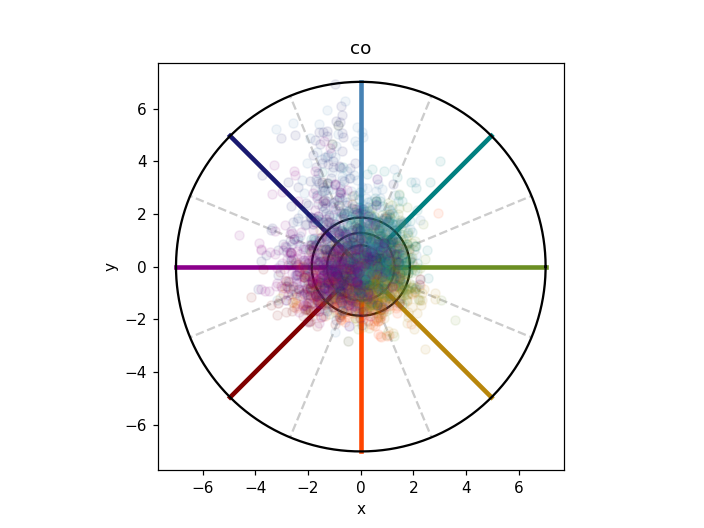

<IPython.core.display.Javascript object>


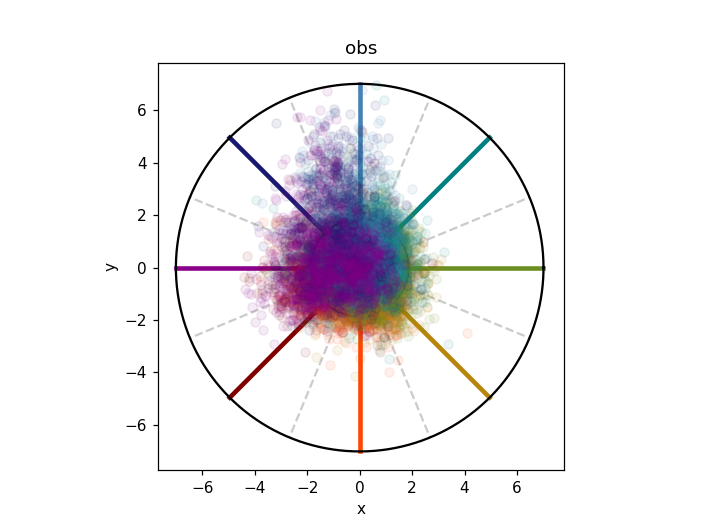

Text(0,0.5,'y')

In [7]:
for task in range(num_tasks):
    plt.figure()
    plt.title(task_list[task])    
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges, target_color)
    for target in range(num_targets):
            task_sel = (df['task'] == task)
            target_sel = (df['target'] == target)
            sel = task_sel & target_sel
            
            x = df['u_vx'][sel]
            y = df['u_vy'][sel]
            plt.scatter(x, y,alpha=0.08,color=target_color[target],zorder=1000)

plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')

In [8]:
def plot_command_bin(): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges, target_color)

<IPython.core.display.Javascript object>


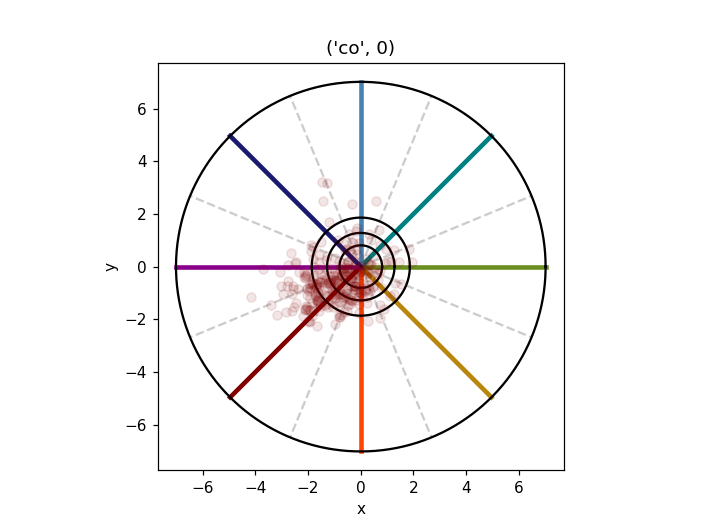

<IPython.core.display.Javascript object>


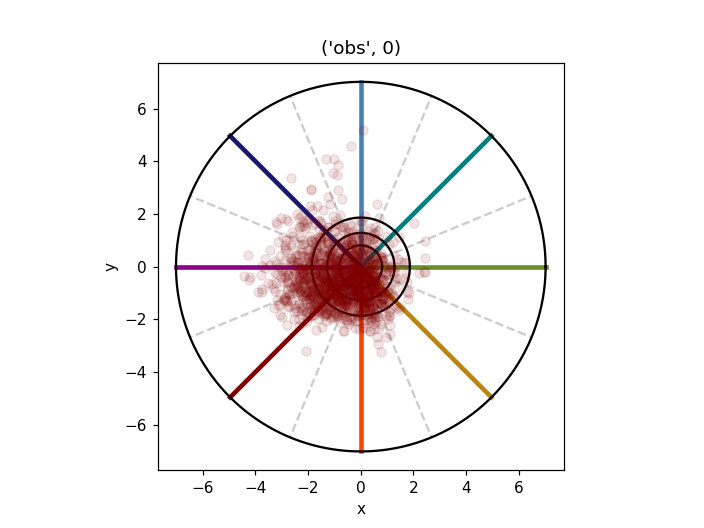

<IPython.core.display.Javascript object>


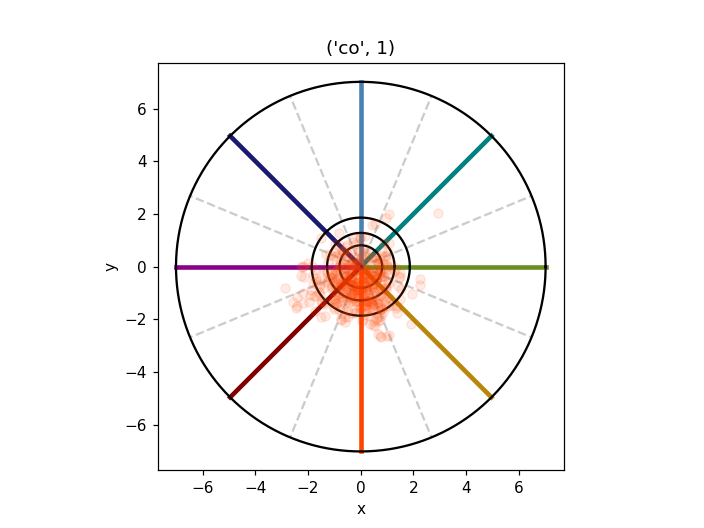

<IPython.core.display.Javascript object>


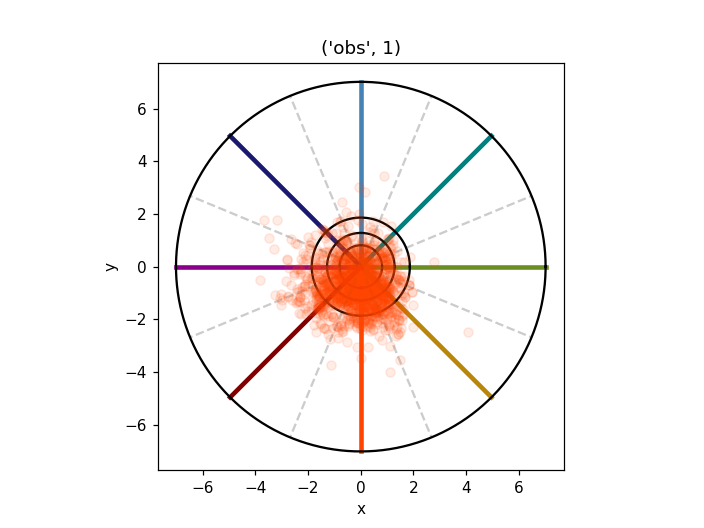

<IPython.core.display.Javascript object>


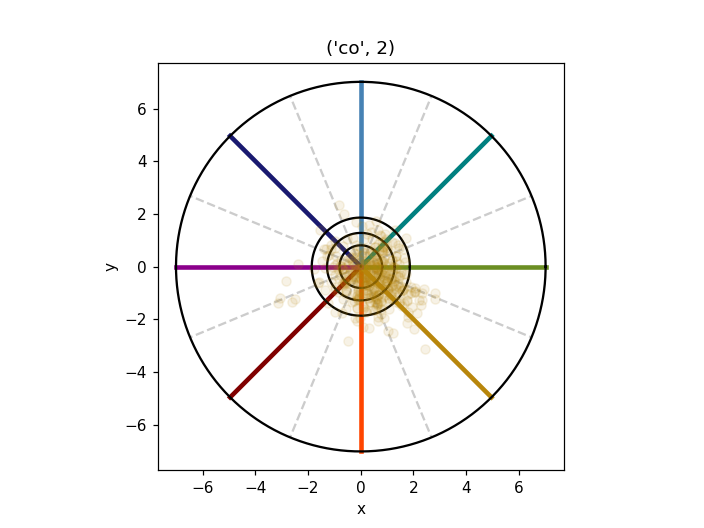

<IPython.core.display.Javascript object>


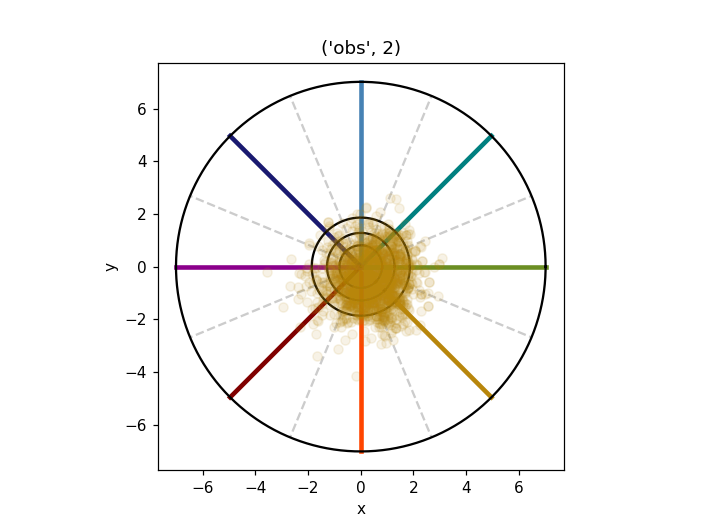

<IPython.core.display.Javascript object>


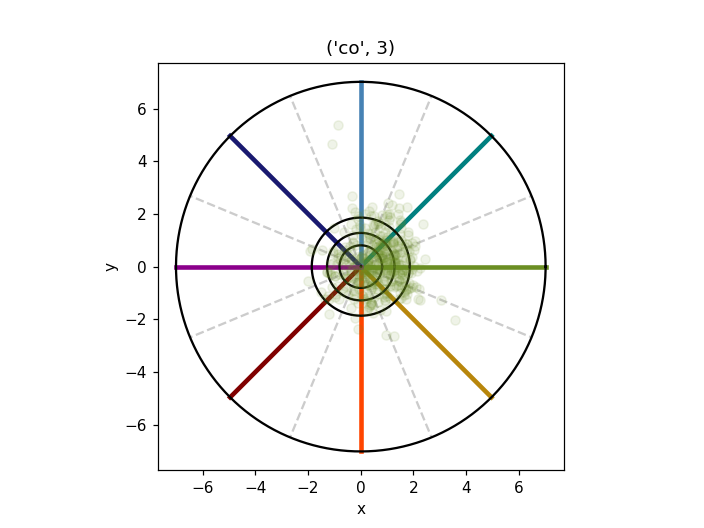

<IPython.core.display.Javascript object>


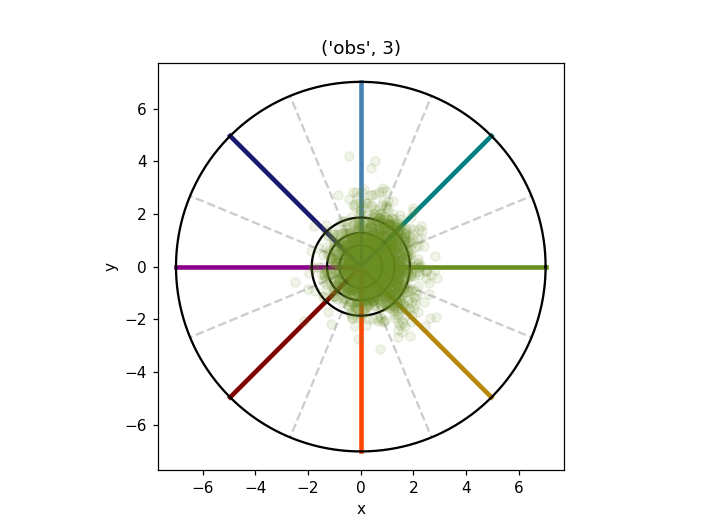

<IPython.core.display.Javascript object>


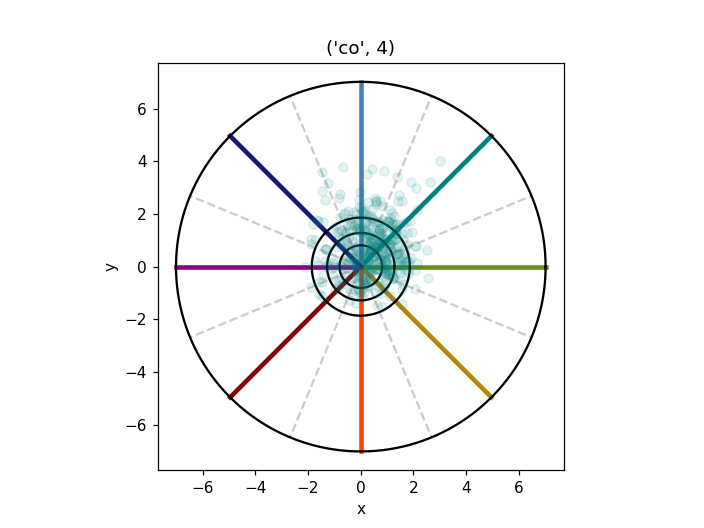

<IPython.core.display.Javascript object>


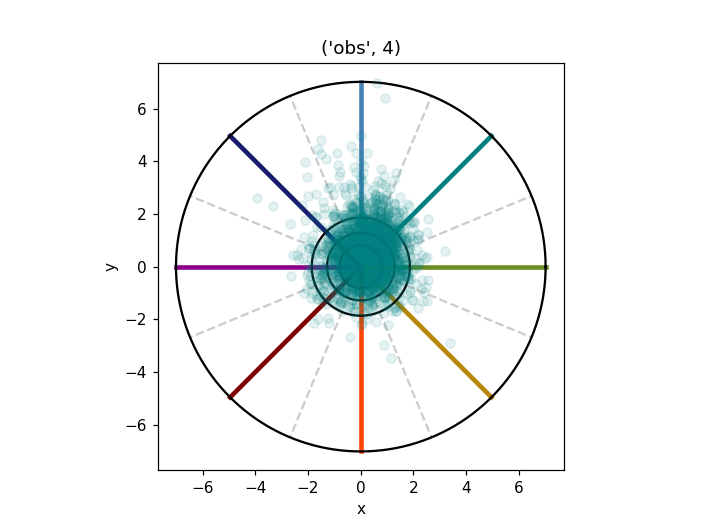

<IPython.core.display.Javascript object>


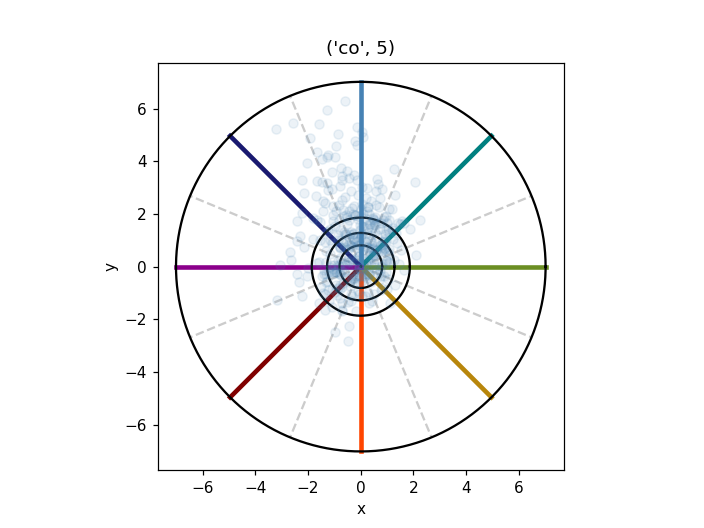

<IPython.core.display.Javascript object>


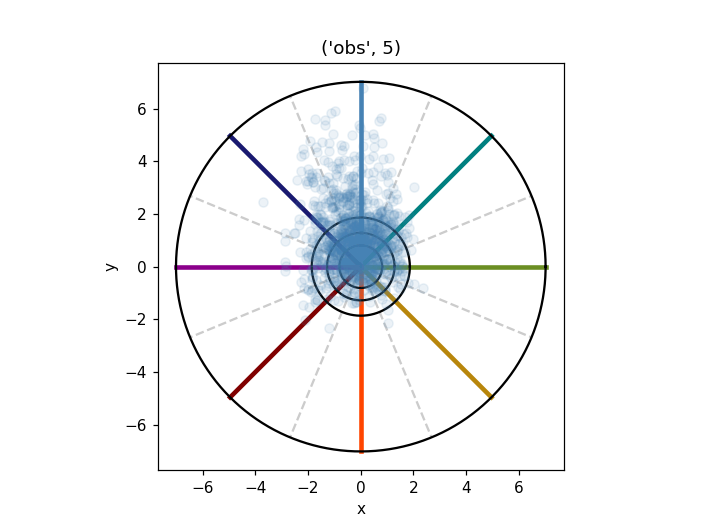

<IPython.core.display.Javascript object>


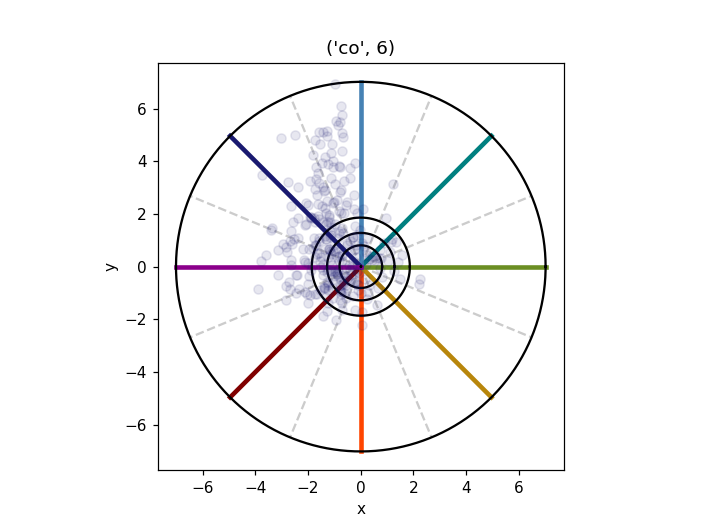

<IPython.core.display.Javascript object>


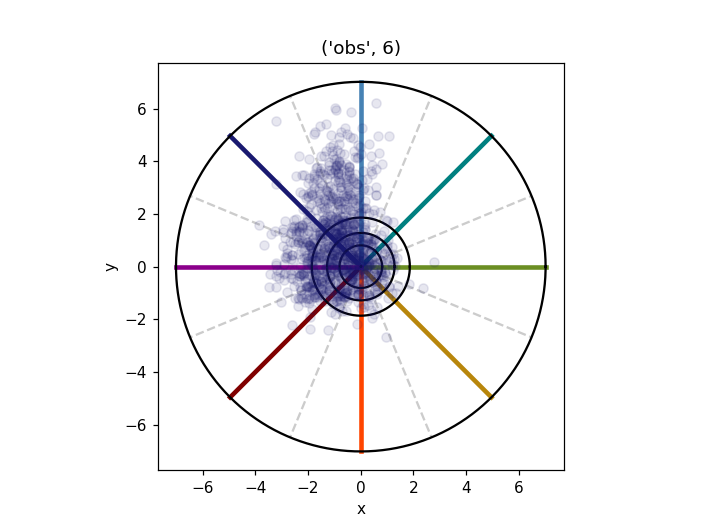

<IPython.core.display.Javascript object>


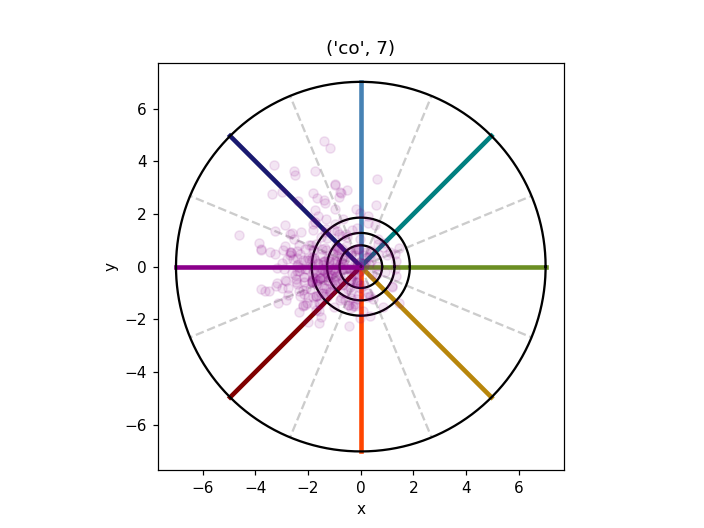

<IPython.core.display.Javascript object>


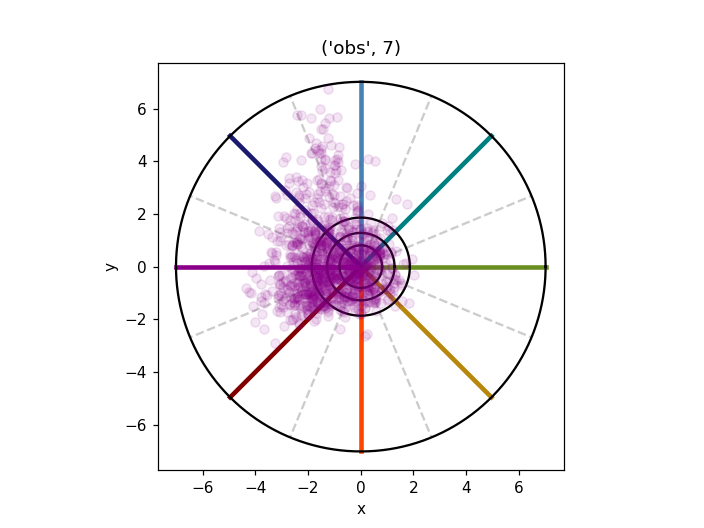

Text(0,0.5,'y')

In [9]:
for target in range(num_targets): #[0]
    for task in range(num_tasks):
        plt.figure()
        plt.title((task_list[task], target))    
        plot_command_bin()        
        
        task_sel = (df['task'] == task)
        target_sel = (df['target'] == target)
        sel = task_sel & target_sel

        x = df['u_vx'][sel]
        y = df['u_vy'][sel]
        plt.scatter(x, y,alpha=0.1,color=target_color[target])

plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')

<IPython.core.display.Javascript object>


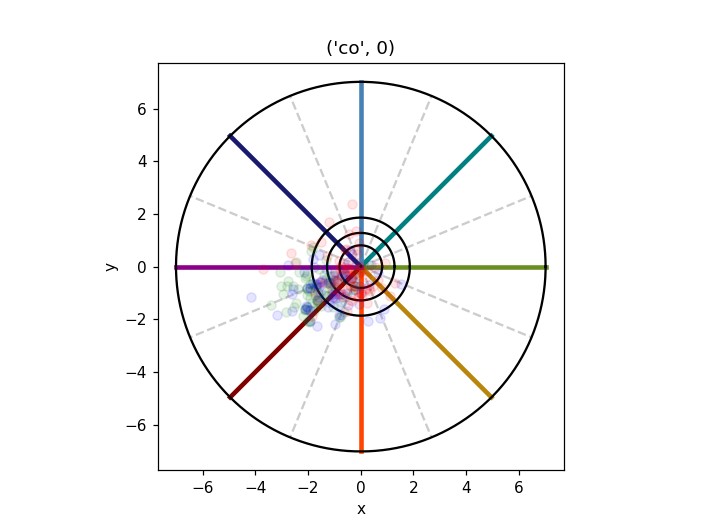

c:\anaconda3\envs\py2\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


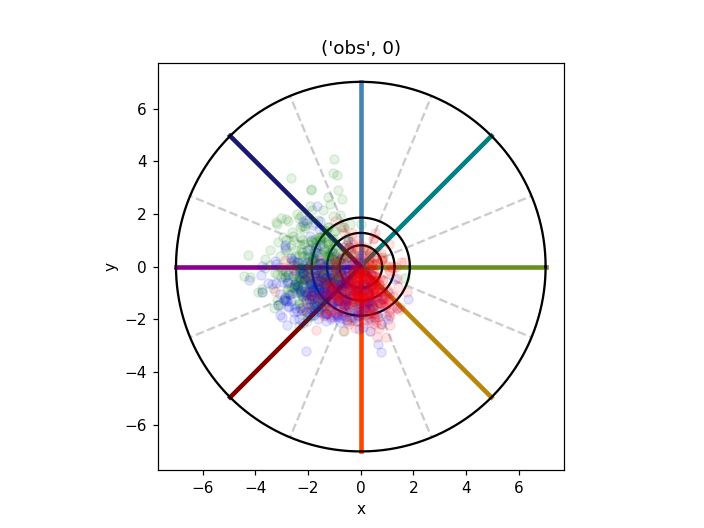

<IPython.core.display.Javascript object>


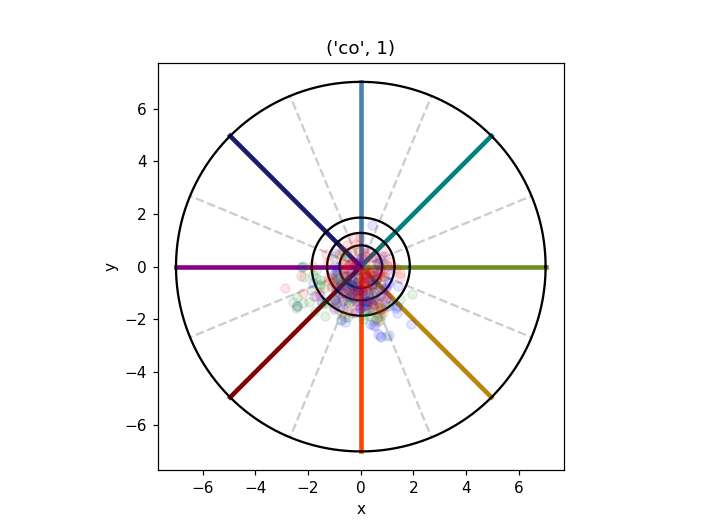

<IPython.core.display.Javascript object>


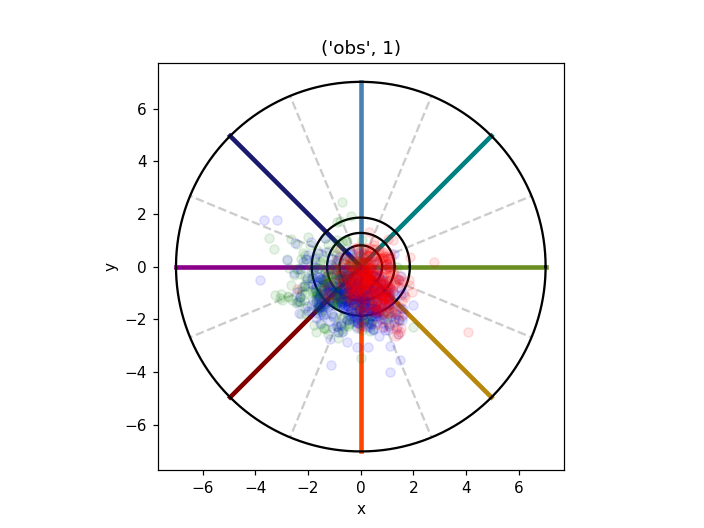

<IPython.core.display.Javascript object>


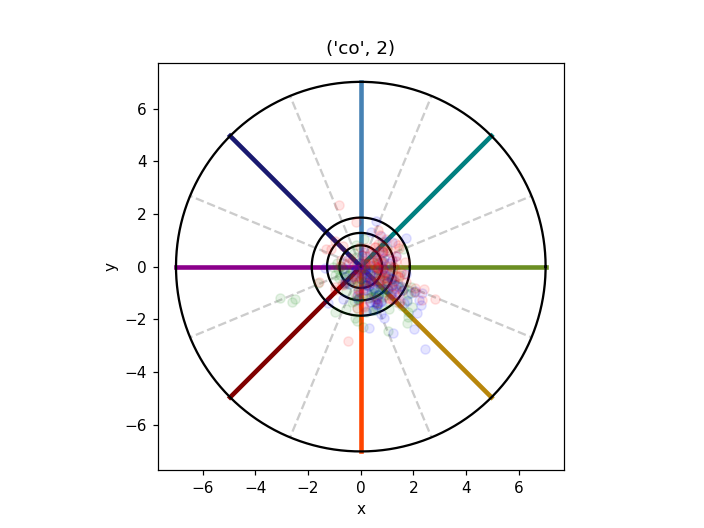

<IPython.core.display.Javascript object>


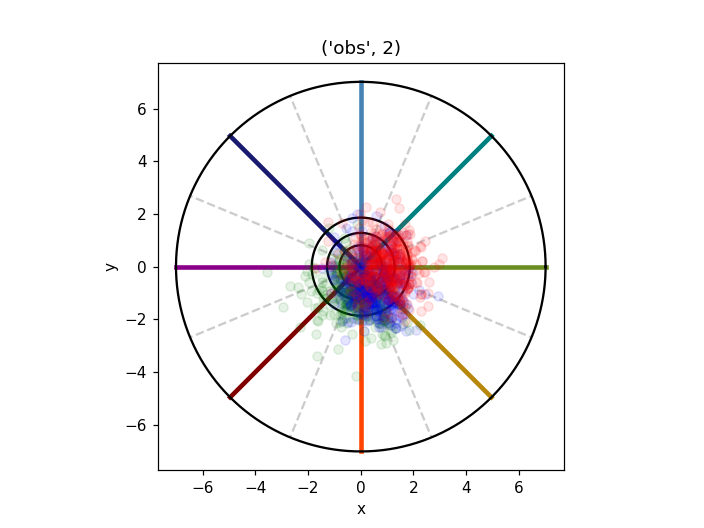

<IPython.core.display.Javascript object>


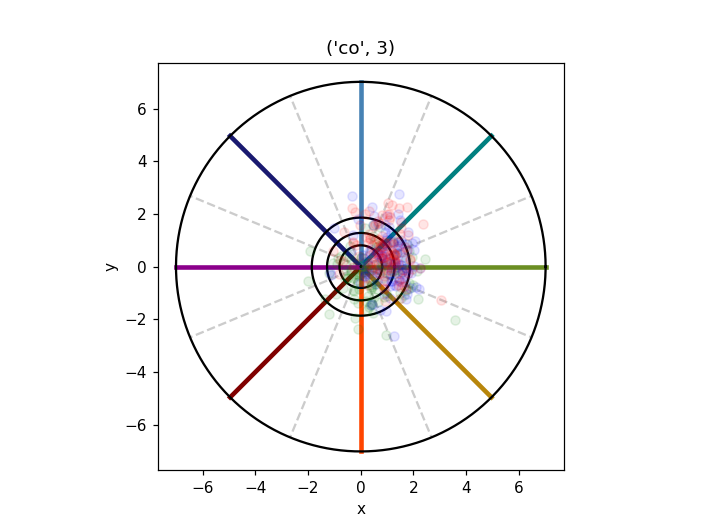

<IPython.core.display.Javascript object>


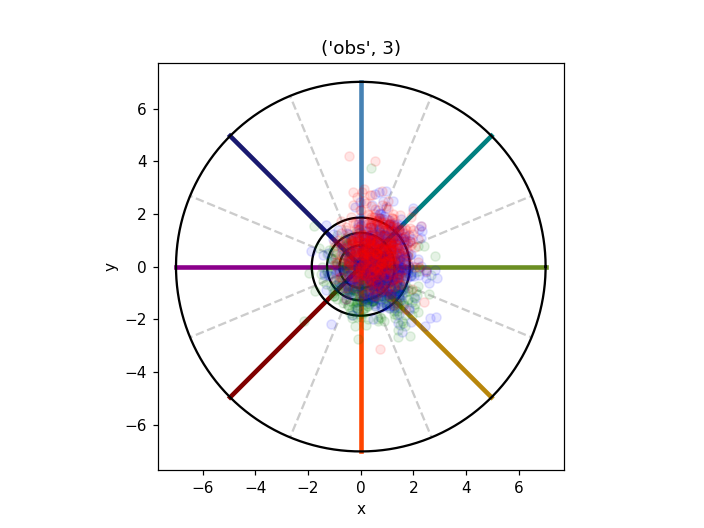

<IPython.core.display.Javascript object>


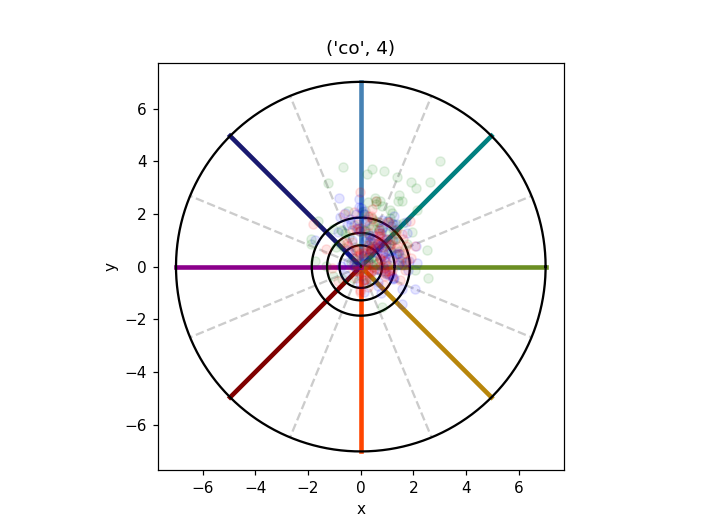

<IPython.core.display.Javascript object>


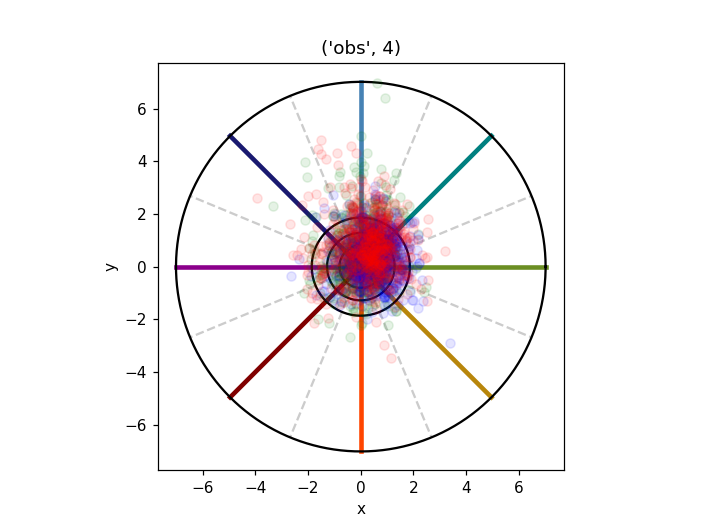

<IPython.core.display.Javascript object>


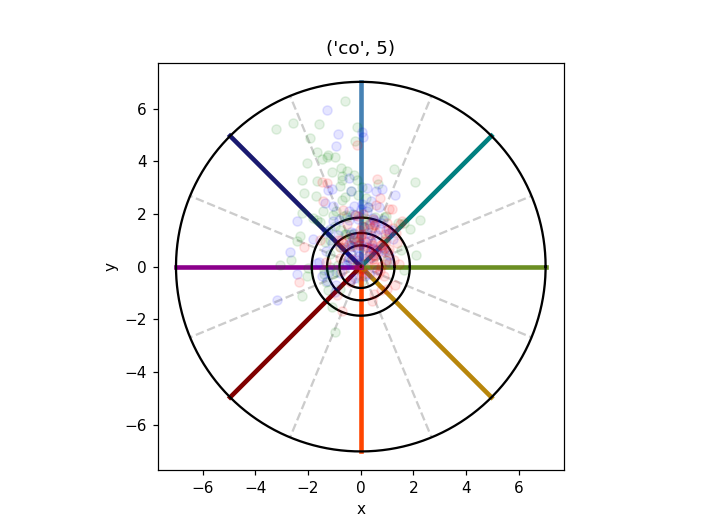

<IPython.core.display.Javascript object>


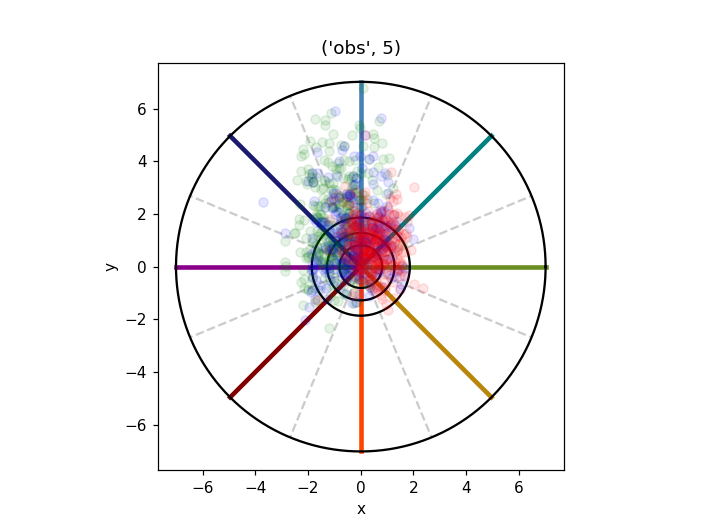

<IPython.core.display.Javascript object>


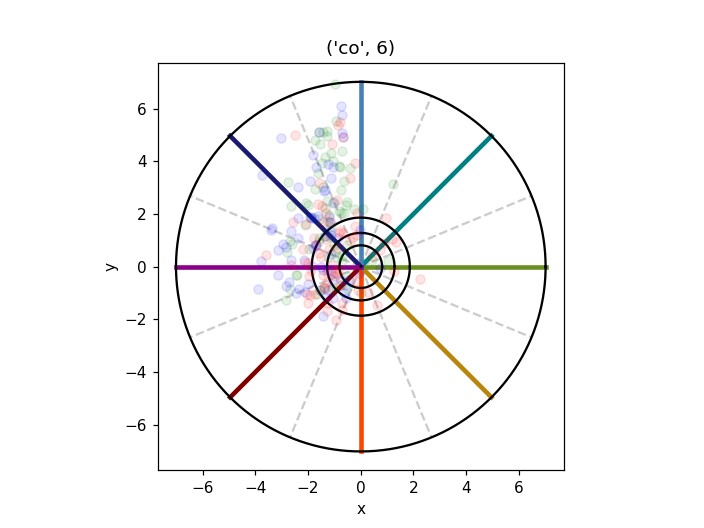

<IPython.core.display.Javascript object>


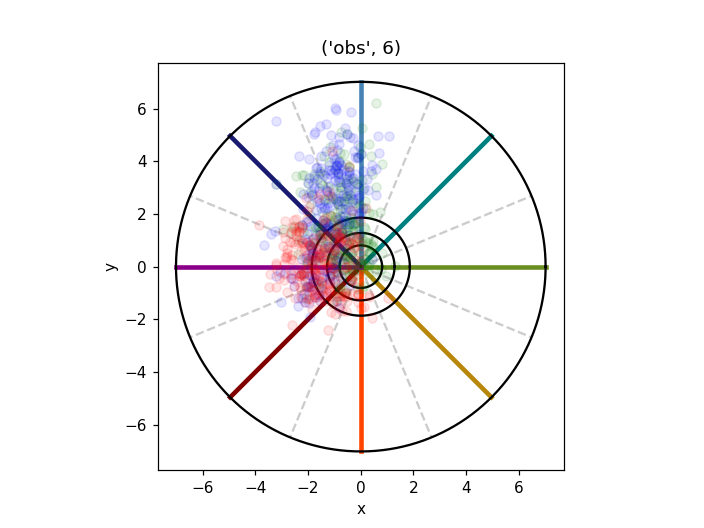

<IPython.core.display.Javascript object>


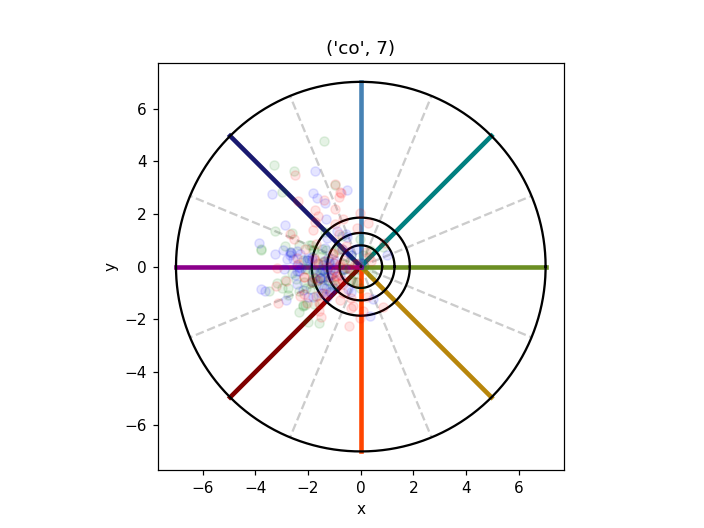

<IPython.core.display.Javascript object>


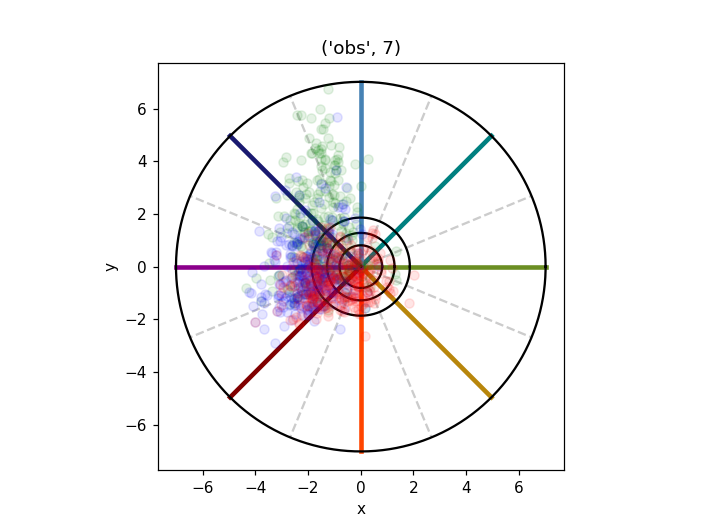

Text(0,0.5,'y')

In [10]:
#early middle late scatter plot
num_phases = 3
phases = np.linspace(0,1,num_phases+1)
trial_phase = np.array([phases[0:-1],phases[1:]])

phase_color = ['g', 'b', 'r'] #maroon
for target in range(num_targets): #[0]
#     plt.subplot(2,3,)
    for task in range(num_tasks):
        plt.figure()
        plot_command_bin()   
        plt.title((task_list[task], target))    
        for phase in range(num_phases):
#             plt.title((task_list[task], target, 'phase: ', phase))    
                 
            task_sel = (df['task'] == task)
            target_sel = (df['target'] == target)
            phase_sel = (df['prog'] >= trial_phase[0,phase]) & (df['prog'] <= trial_phase[1,phase])
            sel = task_sel & target_sel & phase_sel

            x = df['u_vx'][sel]
            y = df['u_vy'][sel]
            plt.scatter(x, y,alpha=0.1,color=phase_color[phase])
# phase_color[phase])#target_color[target])
plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')

### Command-Locked PSTH: 

In [11]:
list(df.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'task',
 'tc',
 'target',
 'trial',
 'bin',
 'trial_start',
 'trial_stop',
 'target_size',
 'obs_size',
 'bin_end',
 'prog',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 'u_v_mag',
 'u_v_angle',
 'p_angle_ctr',
 'v_angle_ctr',
 'u_p_angle_ctr',
 'u_v_angle_ctr',
 'd2target',
 'x_error',
 'y_error',
 'u_v_mag_bin',
 'u_v_angle_bin']

In [12]:
#NOTE: This takes some time...
min_trials = 5
win = [-5,5] #[0, 1]
num_win = win[1]-win[0]+1
num_var = len(list(df.columns))
psth_var = ['u_vx', 'u_vy', 'kin_px', 'kin_py']
task_pairs = [(0,0), (0,1), (1,1)]
if win[0] <= 0:
    zero_lag_idx = -win[0]

task_target_bin_dic=bmi_b.calc_command_trials_dic_da(df, win, num_var, num_tasks, num_targets, num_mag_bins, num_angle_bins)
# diff_df = bmi_b.calc_command_psth_diff(task_target_bin_dic, task_pairs, zero_lag_idx, min_trials, num_targets, num_mag_bins, num_angle_bins)

(0, 0, 0, 0, 8)
(0, 0, 0, 1, 3)
(0, 0, 0, 2, 2)
(0, 0, 0, 3, 3)
(0, 0, 0, 4, 0)
(0, 0, 0, 5, 1)
(0, 0, 0, 6, 2)
(0, 0, 0, 7, 5)
(0, 0, 1, 0, 10)
(0, 0, 1, 1, 7)
(0, 0, 1, 2, 2)
(0, 0, 1, 3, 1)
(0, 0, 1, 4, 0)
(0, 0, 1, 5, 1)
(0, 0, 1, 6, 2)
(0, 0, 1, 7, 3)
(0, 0, 2, 0, 19)
(0, 0, 2, 1, 5)
(0, 0, 2, 2, 2)
(0, 0, 2, 3, 0)
(0, 0, 2, 4, 0)
(0, 0, 2, 5, 2)
(0, 0, 2, 6, 0)
(0, 0, 2, 7, 11)
(0, 0, 3, 0, 29)
(0, 0, 3, 1, 3)
(0, 0, 3, 2, 0)
(0, 0, 3, 3, 0)
(0, 0, 3, 4, 0)
(0, 0, 3, 5, 1)
(0, 0, 3, 6, 1)
(0, 0, 3, 7, 17)
(0, 1, 0, 0, 14)
(0, 1, 0, 1, 14)
(0, 1, 0, 2, 19)
(0, 1, 0, 3, 8)
(0, 1, 0, 4, 4)
(0, 1, 0, 5, 8)
(0, 1, 0, 6, 8)
(0, 1, 0, 7, 5)
(0, 1, 1, 0, 18)
(0, 1, 1, 1, 23)
(0, 1, 1, 2, 14)
(0, 1, 1, 3, 4)
(0, 1, 1, 4, 1)
(0, 1, 1, 5, 3)
(0, 1, 1, 6, 3)
(0, 1, 1, 7, 8)
(0, 1, 2, 0, 9)
(0, 1, 2, 1, 31)
(0, 1, 2, 2, 17)
(0, 1, 2, 3, 1)
(0, 1, 2, 4, 0)
(0, 1, 2, 5, 1)
(0, 1, 2, 6, 0)
(0, 1, 2, 7, 3)
(0, 1, 3, 0, 11)
(0, 1, 3, 1, 17)
(0, 1, 3, 2, 8)
(0, 1, 3, 3, 0)
(0, 1, 3, 4, 0)
(0, 1, 3,

(1, 7, 2, 7, 55)
(1, 7, 3, 0, 96)
(1, 7, 3, 1, 1)
(1, 7, 3, 2, 0)
(1, 7, 3, 3, 1)
(1, 7, 3, 4, 0)
(1, 7, 3, 5, 40)
(1, 7, 3, 6, 72)
(1, 7, 3, 7, 139)


In [13]:
bmi_b.calc_command_psth_center_at_lag(task_target_bin_dic, psth_var, zero_lag_idx, min_trials, num_tasks, num_targets, num_mag_bins, num_angle_bins)

In [14]:
task_target_bin_dic[0,0,1,0,'psth']

<xarray.DataArray (var: 4, time: 11)>
array([[ 0.010896,  0.113539,  0.147042, -0.550102, -0.739843,  0.      ,
        -0.17697 , -0.388018, -0.095565,  0.025747,  0.245856],
       [ 0.190328,  0.035337, -0.08345 , -0.01154 , -0.052563,  0.      ,
        -0.084201,  0.088192, -0.075514,  0.075478, -0.053975],
       [ 0.976932,  0.818161,  0.679384,  0.48156 ,  0.221295,  0.      ,
        -0.204711, -0.425774, -0.629988, -0.807798, -0.947969],
       [ 0.938128,  0.766911,  0.579321,  0.38836 ,  0.19305 ,  0.      ,
        -0.199288, -0.38614 , -0.579696, -0.76478 , -0.955553]])
Coordinates:
  * var      (var) |S13 'u_vx' 'u_vy' 'kin_px' 'kin_py'
  * time     (time) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5

<IPython.core.display.Javascript object>


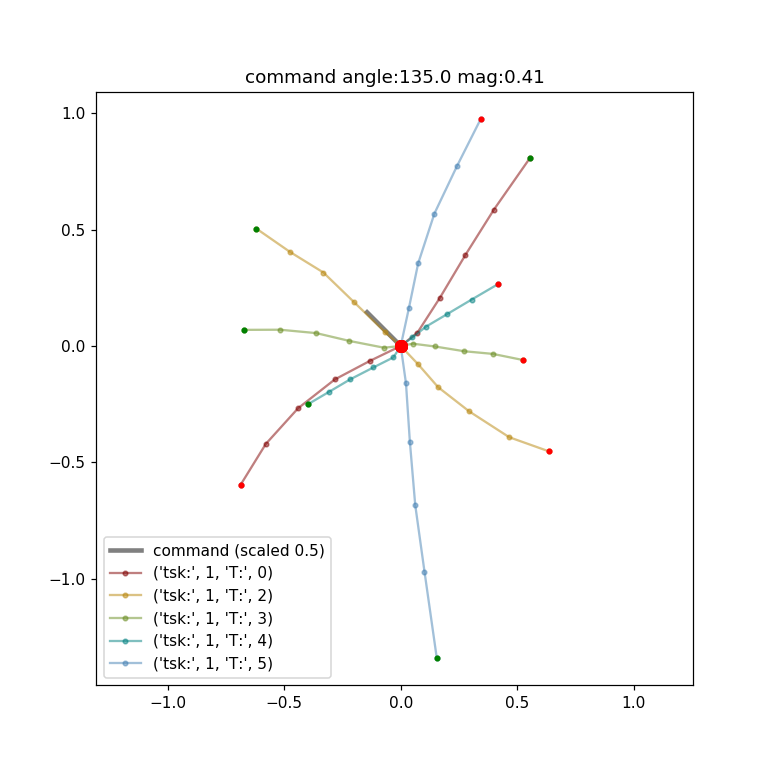

(1, 0, 13)
(1, 2, 13)
(1, 3, 31)
(1, 4, 50)
(1, 5, 19)


<IPython.core.display.Javascript object>


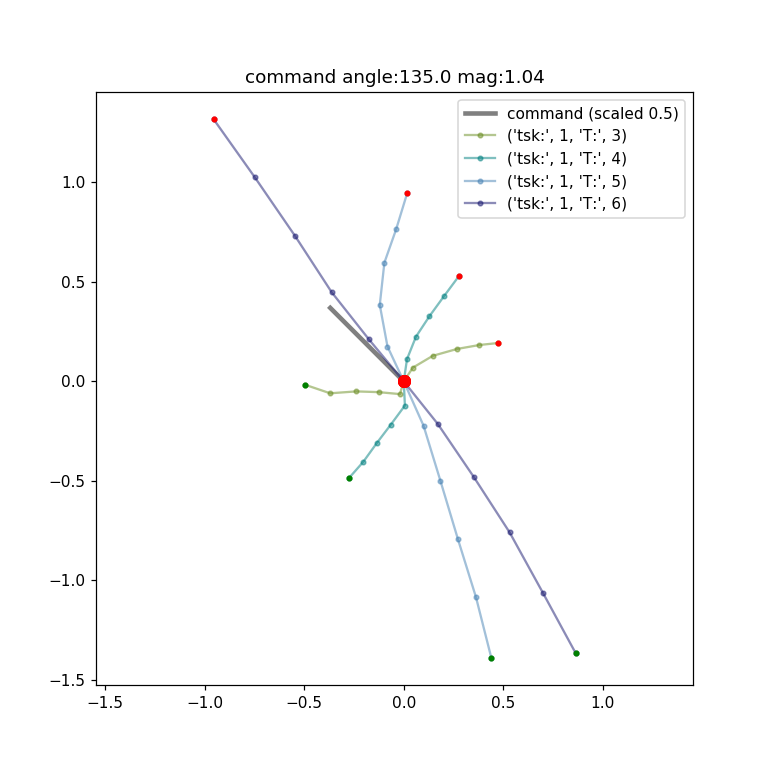

(1, 3, 15)
(1, 4, 40)
(1, 5, 25)
(1, 6, 10)


<IPython.core.display.Javascript object>


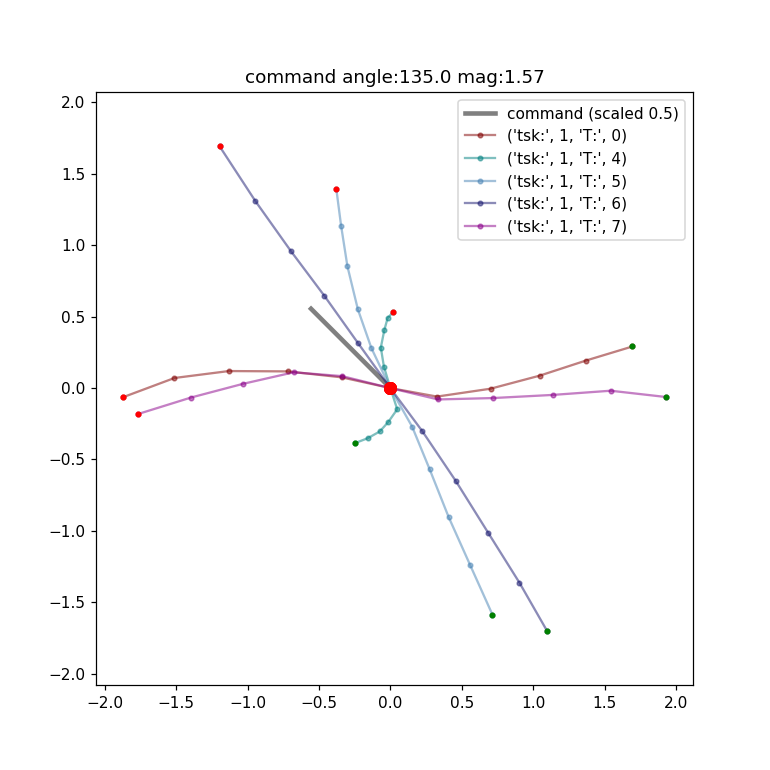

(1, 0, 13)
(1, 4, 21)
(1, 5, 32)
(1, 6, 24)
(1, 7, 17)


<IPython.core.display.Javascript object>


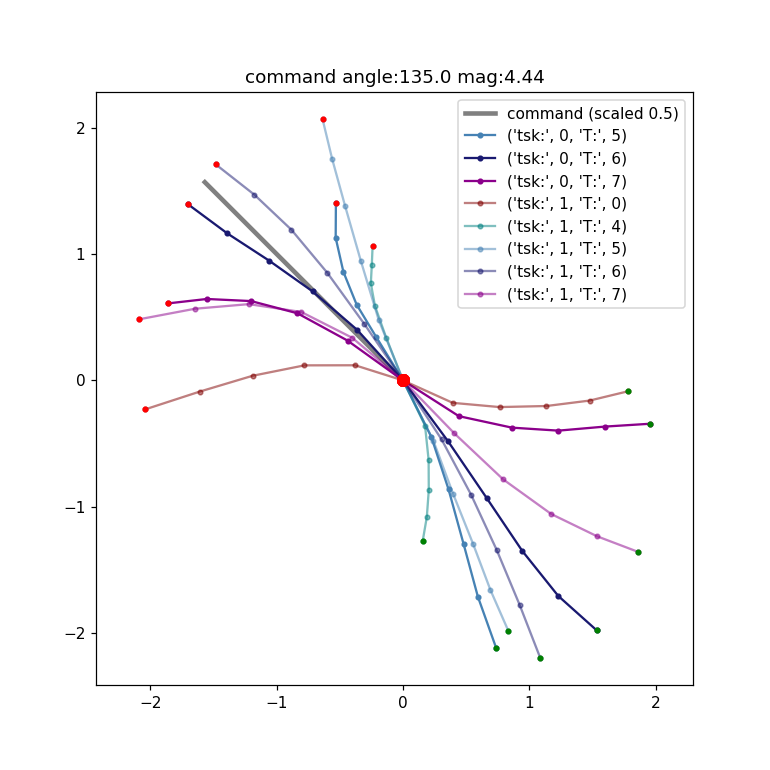

(0, 5, 13)
(0, 6, 32)
(0, 7, 15)
(1, 0, 32)
(1, 4, 23)
(1, 5, 55)
(1, 6, 90)
(1, 7, 72)


In [26]:
min_trials_plot = 10 #10
# mag_bin = 1
angle_bin = 6
sc = 0.5

#PLOT COMMAND: 

for mag_bin in [0, 1,2,3]:
    pm = mag_bin_c[mag_bin]
    pa = angle_bin_c[angle_bin]
    x_bin = pm*np.cos(pa)*sc
    y_bin = pm*np.sin(pa)*sc
    
    #-----------------------------------------------------------------------------------------------------------------
    plt.figure(figsize=(7,7))
    ax = plt.gca()
    plt.plot([0, x_bin], [0, y_bin], color=np.ones(3)*0.5, linewidth=3, label='command (scaled ' + str(sc)+')')
    task_alpha = [1, 0.5]
    for task in range(0,num_tasks):
        for target in range(0,num_targets):
            num_trials = task_target_bin_dic[task, target, mag_bin, angle_bin, 'num']
            if num_trials >= min_trials_plot:
                print(task, target, num_trials)
                data = task_target_bin_dic[task, target, mag_bin, angle_bin, 'psth']
                plt.plot(data.loc['kin_px'], data.loc['kin_py'], '.-', alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target))
                plt.plot(data.loc['kin_px', 0], data.loc['kin_py', 0], '.-', color='r', markersize=15)   
                plt.plot(data.loc['kin_px', win[1]], data.loc['kin_py', win[1]], '.-', color='r') #color=np.ones(3)*0.0
                plt.plot(data.loc['kin_px', win[0]], data.loc['kin_py', win[0]], '.-', color='g')  
    plt.axis('equal')
#     ax.set_aspect('equal')
    plt.legend()
    plt.title('command angle:'+str(round(pa*180/np.pi,2)) + ' mag:' + str(round(pm,2)))
    

In [27]:
df['bin_end']

0        54.0
1        53.0
2        52.0
3        51.0
4        50.0
5        49.0
6        48.0
7        47.0
8        46.0
9        45.0
10       44.0
11       43.0
12       42.0
13       41.0
14       40.0
15       39.0
16       38.0
17       37.0
18       36.0
19       35.0
20       34.0
21       33.0
22       32.0
23       31.0
24       30.0
25       29.0
26       28.0
27       27.0
28       26.0
29       25.0
         ... 
14688    29.0
14689    28.0
14690    27.0
14691    26.0
14692    25.0
14693    24.0
14694    23.0
14695    22.0
14696    21.0
14697    20.0
14698    19.0
14699    18.0
14700    17.0
14701    16.0
14702    15.0
14703    14.0
14704    13.0
14705    12.0
14706    11.0
14707    10.0
14708     9.0
14709     8.0
14710     7.0
14711     6.0
14712     5.0
14713     4.0
14714     3.0
14715     2.0
14716     1.0
14717     0.0
Name: bin_end, Length: 14718, dtype: float64

In [28]:
task_sel = (df['task']==task)
target_sel = (df['target']==target)
# trial_sel = (df['bin']>=0) 
trial_start = (df['bin']==0) & task_sel & target_sel
trial_stop = (df['bin_end']==0) & task_sel & target_sel

In [44]:
list(df.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'task',
 'tc',
 'target',
 'trial',
 'bin',
 'trial_start',
 'trial_stop',
 'target_size',
 'obs_size',
 'bin_end',
 'prog',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 'u_v_mag',
 'u_v_angle',
 'p_angle_ctr',
 'v_angle_ctr',
 'u_p_angle_ctr',
 'u_v_angle_ctr',
 'd2target',
 'x_error',
 'y_error',
 'u_v_mag_bin',
 'u_v_angle_bin']

In [ ]:
#Plot only a few trials
#(Later can think about )

In [75]:
df = df.drop('trial_global', axis=1)

In [80]:
df.iloc[-1,:]

n_0                 1.000000
n_1                 0.000000
n_2                 1.000000
n_3                 0.000000
n_4                 1.000000
n_5                 1.000000
n_6                 0.000000
n_7                 1.000000
n_8                 0.000000
n_9                 0.000000
n_10                0.000000
n_11                0.000000
n_12                0.000000
n_13                0.000000
n_14                0.000000
n_15                1.000000
n_16                0.000000
n_17                0.000000
n_18                0.000000
n_19                0.000000
n_20                0.000000
n_21                0.000000
n_22                1.000000
n_23                3.000000
n_24                0.000000
n_25                0.000000
n_26                1.000000
n_27                0.000000
n_28                1.000000
n_29                1.000000
                    ...     
kin_vy             -0.690618
task                1.000000
tc               4382.000000
target        

In [71]:
cond_sel = (df['task']==task) & (df['target']==target)
trial_start = (df['bin']==0) & cond_sel 
trial_stop = (df['bin_end']==0) & cond_sel
trial_bnd = np.vstack((np.where(trial_start)[0], np.where(trial_stop)[0]))
for i,bnd in enumerate(trial_bnd.T):
    print(bnd)
    x = df['trial'][bnd[0]]
    print(x)

3.0
14.0
20.0
28.0
33.0
36.0
52.0
58.0
66.0
71.0
81.0
88.0
99.0
3.0
14.0
20.0
28.0
33.0
36.0
52.0
58.0
66.0
71.0
81.0
88.0
99.0
106.0


In [91]:
which_trial_sel

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10        True
11        True
12        True
13        True
14        True
15        True
16        True
17        True
18        True
19        True
20        True
21        True
22        True
23        True
24        True
25        True
26        True
27        True
28        True
29        True
         ...  
14688    False
14689    False
14690    False
14691    False
14692    False
14693    False
14694    False
14695    False
14696    False
14697    False
14698    False
14699    False
14700    False
14701    False
14702    False
14703    False
14704    False
14705    False
14706    False
14707    False
14708    False
14709    False
14710    False
14711    False
14712    False
14713    False
14714    False
14715    False
14716    False
14717    False
Name: trial_cond, Length: 14718, dtype: bool

In [92]:
trial_bnd

array([[7706],
       [7733]], dtype=int64)

<IPython.core.display.Javascript object>


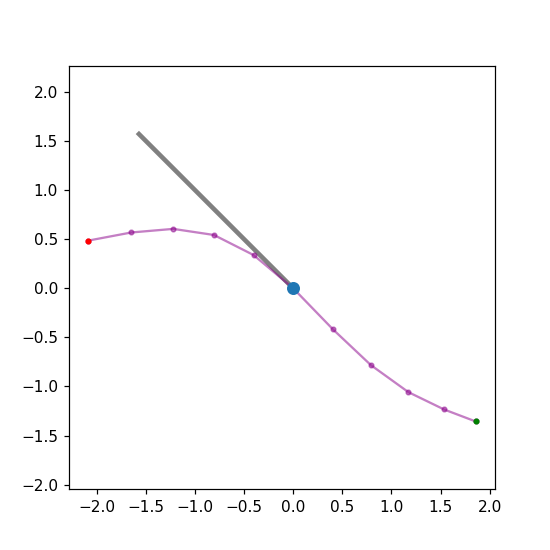

<IPython.core.display.Javascript object>


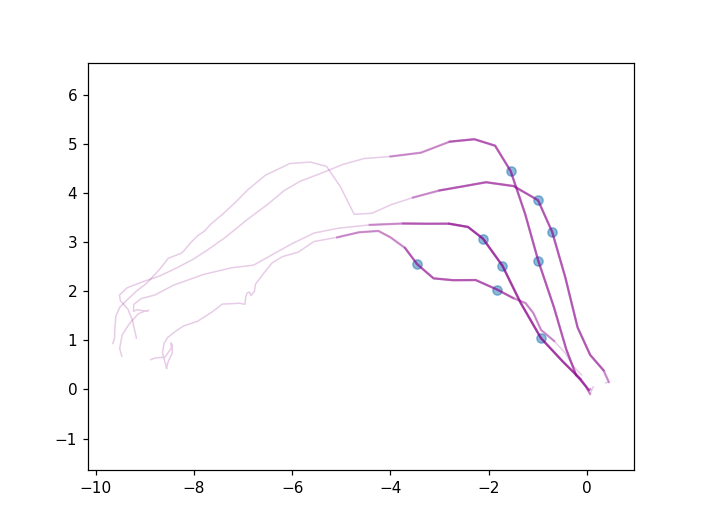

[7866 7900]
[7911 7945]
[7956 7995]
[8133 8184]


In [117]:
#c-l psth: command-locked psth
#For each c-l psth, I want to plot individual trajectories and show the commands 
mag_bin = 3
ang_bin = 6
task =1
target = 7
num_trials = task_target_bin_dic[task, target, mag_bin, angle_bin, 'num']

#PLOT:
#CHOOSE WHICH TRIALS:
#----------------------------------------------------------------------------------------------
which_trials = np.array([4,5,6,10]) #4,5,6
#decent:
#1,2,3 ,4, 5
#good: 
#4,5, 6,10

#----------------------------------------------------------------------------------------------

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']



#PLOT PSTH
data = task_target_bin_dic[task, target, mag_bin, angle_bin, 'psth']
plt.figure(figsize=(5,5))

plt.plot([0, x_bin], [0, y_bin], color=np.ones(3)*0.5, linewidth=3, label='command (scaled ' + str(sc)+')')

plt.plot(data.loc['kin_px'], data.loc['kin_py'], '.-', alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target))
plt.plot(data.loc['kin_px', 0], data.loc['kin_py', 0], '.-', color=cycle[0], markersize=15)   
plt.plot(data.loc['kin_px', win[1]], data.loc['kin_py', win[1]], '.-', color='r') #color=np.ones(3)*0.0
plt.plot(data.loc['kin_px', win[0]], data.loc['kin_py', win[0]], '.-', color='g')  
plt.axis('equal')

#PLOT TRIALS: 
cond_sel = (df['task']==task) & (df['target']==target)

#Only select certain trials:
which_trial_sel = (df['trial_cond']==which_trials[0])
for i,t in enumerate(which_trials):
    which_trial_sel = which_trial_sel | (df['trial_cond']==which_trials[i])
    
trial_start = (df['bin']==0) & cond_sel & which_trial_sel
trial_stop = (df['bin_end']==0) & cond_sel & which_trial_sel
trial_bnd = np.vstack((np.where(trial_start)[0], np.where(trial_stop)[0]))
# plt.figure(figsize=(5,5))
plt.figure()
for i,bnd in enumerate(trial_bnd.T):
    
    print(bnd)
    x = df['kin_px'][bnd[0]:bnd[1]+1]
    y = df['kin_py'][bnd[0]:bnd[1]+1]
    color = target_color[target]
    plt.plot(x,y,'-',linewidth=1, color=color, alpha=0.2)

#PLOT COMMAND-LETS:     
command_sel = (df['u_v_mag_bin']==mag_bin)&(df['u_v_angle_bin']==angle_bin)
intra_trial_sel = (df['bin']>=5)&(df['bin_end']>=5)
command_trial_sel = command_sel&cond_sel&intra_trial_sel*which_trial_sel
plt.scatter(df.loc[command_trial_sel, 'kin_px'], df.loc[command_trial_sel, 'kin_py'], color=cycle[0], alpha=0.5) 
plt.axis('equal')

c_win = np.array([-5, 5])
ca = np.where(command_trial_sel)[0]
for c in ca:
    w = c_win+c
    x = df['kin_px'][w[0]:w[1]+1]
    y = df['kin_py'][w[0]:w[1]+1]
    plt.plot(x,y,'-',color=color,alpha=0.35)



In [38]:
task_target_bin_dic.keys()

[(0, 1, 0, 2, 'num'),
 (1, 4, 0, 7),
 (1, 7, 3, 3),
 (0, 2, 2, 4),
 (0, 6, 0, 5),
 (1, 4, 1, 7, 'psth', 0),
 (0, 0, 2, 2, 'num'),
 (1, 4, 2, 4, 'psth_trials', 1),
 (0, 6, 2, 7, 'num'),
 (1, 1, 0, 5),
 (1, 6, 1, 0, 'psth_trials', 0),
 (1, 3, 2, 6, 'num'),
 (0, 1, 0, 3),
 (1, 0, 0, 7, 'psth_trials', 1),
 (1, 4, 1, 3, 'psth', 0),
 (0, 3, 1, 6),
 (0, 0, 2, 2),
 (0, 1, 0, 7, 'psth_trials', 1),
 (0, 5, 1, 1, 'num'),
 (1, 3, 3, 4, 'num'),
 (1, 6, 2, 7, 'psth'),
 (0, 2, 1, 1),
 (1, 5, 0, 4, 'num'),
 (1, 2, 2, 0, 'psth_trials', 1),
 (1, 6, 3, 6, 'psth'),
 (1, 6, 0, 4),
 (1, 3, 1, 3, 'psth', 1),
 (0, 5, 2, 4, 'num'),
 (1, 0, 0, 7, 'psth'),
 (0, 4, 0, 0),
 (1, 4, 1, 3, 'psth', 1),
 (1, 1, 1, 0, 'psth'),
 (1, 7, 2, 7, 'psth'),
 (0, 2, 2, 1, 'psth_trials', 0),
 (1, 7, 2, 1),
 (1, 6, 3, 4, 'num'),
 (0, 6, 3, 3),
 (0, 1, 1, 7, 'psth'),
 (0, 5, 0, 5, 'psth_trials', 1),
 (1, 5, 0, 0, 'psth_trials', 0),
 (0, 3, 3, 6, 'num'),
 (0, 5, 3, 6, 'num'),
 (1, 5, 1, 6),
 (0, 3, 0, 1, 'psth_trials', 0),
 (0, 1, 1

In [ ]:
#position-center: 

<IPython.core.display.Javascript object>


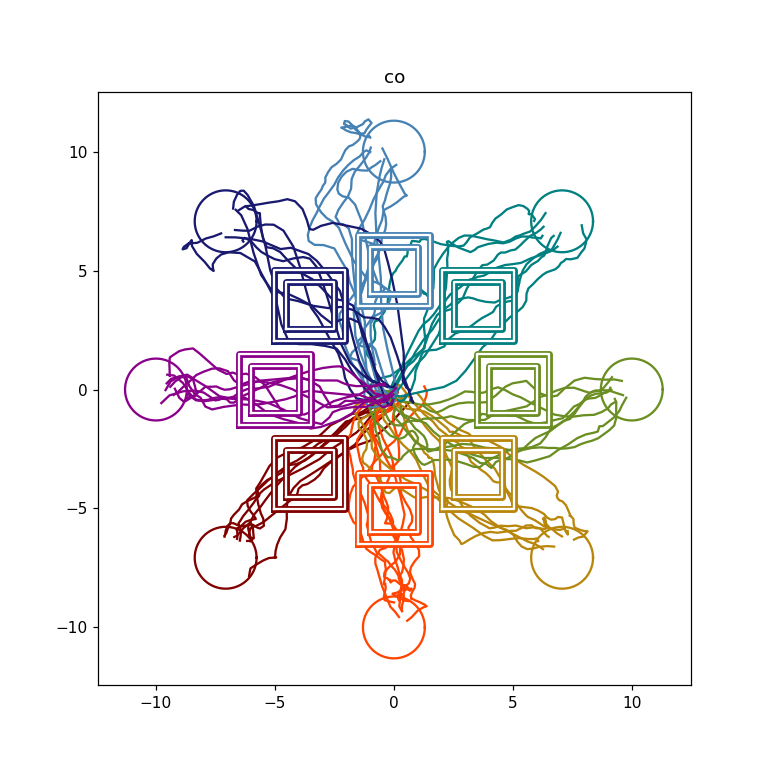

<IPython.core.display.Javascript object>


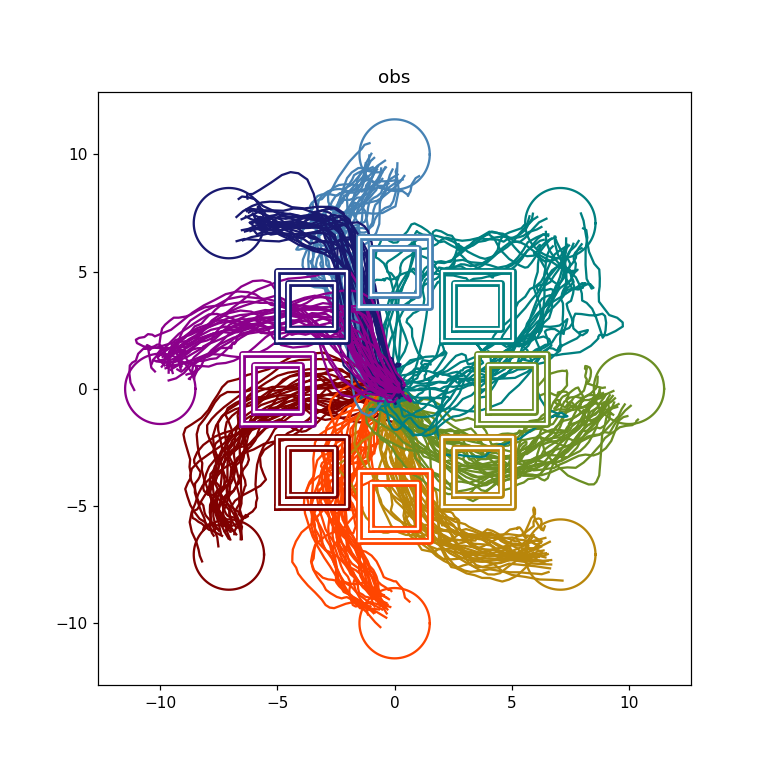

In [22]:
#PLOT INDIVIDUAL TRIALS: 
save_bool = False
plt_prefix = 'trials'
plt_ext = ['.png', '.eps']

plot={}
plot['size'] = (7,7)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)

plot_obs_subset = False
plot_obs_small_trials = False
plot_obs_big_trials = True


plot_target = True
plot_obs_small = True
plot_obs_big = True

for task_str in task_list:
    task = task2idx[task_str]
    plt.figure(figsize=plot['size'])
    for target in range(num_targets):
        if task_str == 'co' or (task_str == 'obs' and plot_obs_subset == False): 
            sel = (df['task']==task) & (df['bin']>=0) & (df['target']==target)
        elif task_str == 'obs' and plot_obs_small_trials:
            sel = (df['task']==task) & (df['bin']>=0) & (df['target']==target) & (df['obs_size']==obs_small)
        elif task_str == 'obs' and plot_obs_big_trials:
            sel = (df['task']==task) & (df['bin']>=0) & (df['target']==target) & (df['obs_size']==obs_big)
             
        df_sel = df[sel]
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where(df_sel['bin']==0)[0]
        trial_stop = np.hstack((trial_start[1:]-1, len(np.where(sel)[0])))
        trial_bound = np.vstack((trial_start,trial_stop)).T
        #------------------------------------------------------------------------------------
        for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
#             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
            x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
            y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
            color = target_color[target]
            plt.plot(x,y,'-',color=color)

    if plot_obs_small:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
    if plot_obs_big:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
    if plot_target: 
        bmi_util.plot_targets(target_pos, target_color, target_r_eff[task]*np.ones(num_targets))  
    
    plt.axis('square')
    plt.title(task_str)
#     plt.xlim(plot['xlim'])
#     plt.ylim(plot['ylim'])
    plt.show()
    
    if save_bool: 
        plt_name = plt_prefix + '_' + task_str
        for ext in plt_ext:
            plt.savefig(os.path.join(save_dir, plt_name+ext))    
    